## Bloomburrow Modeling

1. Imports and data loading
2. Initial feature engineering and pre-calculation
3. First Neural Network attempt
4. Synergy feature development (should be moved to a separate file/script?)
5. NN refinement

### Imports / Data Loading

In [ ]:
# Data Handling & Computation
import pandas as pd
import numpy as np
import os
from scipy.stats import pearsonr

# Machine Learning Models
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from keras_tuner import HyperParameters
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Metrics & Visualization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


ImportError: Traceback (most recent call last):
  File "c:\Users\aaeam\anaconda3\envs\win_c0c1\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
#TODO clean this up

color_list = ["W", "U", "B", "R", "G"]
basic_lands = {"Plains", "Island", "Swamp", "Mountain", "Forest"}

def get_blb_data():
    """Retrieves games data, prioritizing cached data, then Parquet, and finally CSV."""

    parquet_file = f"data/blb/games.parquet"

    if os.path.exists(parquet_file):
        print(f"Loading game data for Bloomburrow from Parquet file...")
        df = pd.read_parquet(parquet_file, engine='fastparquet')
        return df
    raise FileNotFoundError(f"No data blb parquet found")


In [ ]:
df = get_blb_data()

Loading game data for blb from Parquet file...


In [ ]:

# Identify columns to keep
columns_to_keep = ["draft_id", "rank", "main_colors", "splash_colors", "won"] + [
    col for col in games_df.columns if col.startswith("deck_")
]

# Drop all other columns
filtered_df = filtered_df[columns_to_keep]

# Example usage:
selected_games_df = filter_drafts(df, num_drafts=5000)

# Convert boolean values to integers (True = 1, False = 0)
selected_games_df["won"] = selected_games_df["won"].astype(int)

# Calculate wins and losses per draft ID
selected_games_df["wins"] = selected_games_df.groupby("draft_id")["won"].transform("sum")
selected_games_df["losses"] = selected_games_df.groupby("draft_id")["won"].transform("count") - selected_games_df["wins"]
# drop incomplete drafts and buggy drafts (8 wins, 4 losses e.g.)
selected_games_df = selected_games_df[selected_games_df["wins"].isin([7]) | selected_games_df["losses"].isin([3])]
num_main_changes = (
    selected_games_df.groupby("draft_id")["main_colors"]
    .nunique()
    .gt(1)  # True if more than one unique value
    .sum()  # Count occurrences
)
num_splash_changes = (
    selected_games_df.groupby("draft_id")["splash_colors"]
    .nunique()
    .gt(1)
    .sum()
)
print(f"Drafts with main color changes: {num_main_changes}")
print(f"Drafts with splash color changes: {num_splash_changes}")
# Calculate win rate
selected_games_df["win_rate"] = selected_games_df["wins"] / (selected_games_df["wins"] + selected_games_df["losses"])
selected_games_df = selected_games_df.drop_duplicates(subset=["draft_id"])
#TODO investigate any deck redesigns
selected_games_df.head()

In [ ]:
file_path = f"data/blb/cards.csv"
print(f"Loading Scryfall data for blb from existing file...")
cards_df = pd.read_csv(file_path)

ratings_df = pd.read_csv("data/blb/card-ratings.csv")
ratings_df.head(2)

Loading Scryfall data for blb from existing file...


,Name,Color,Rarity,# Seen,ALSA,# Picked,ATA,# GP,% GP,GP WR,# OH,OH WR,# GD,GD WR,# GIH,GIH WR,# GNS,GNS WR,IWD
0,Banishing Light,W,C,207601,3.17,53955,3.96,292583,89.4%,55.1%,48910,54.0%,67596,57.0%,116506,55.7%,175185,54.7%,1.0pp
1,"Beza, the Bounding Spring",W,M,7230,1.46,4829,1.43,26113,87.6%,57.1%,4508,62.2%,6233,62.7%,10741,62.5%,15368,53.3%,9.2pp


##### 17Lands Data Field Descriptions  
(Compiled with assistance from Microsoft Copilot, edited)

- **Name**: The card's name.  
- **Color**: The card's primary color identity.  
- **Rarity**: The card's rarity (Common, Uncommon, Rare, Mythic).  
- **# Seen**: Total instances of the card appearing in draft packs.  
- **ALSA (Average Last Seen At)**: The average pick number where the card is still available. Lower values indicate highly desirable picks.  
- **ATA (Average Taken At)**: The average pick number where the card is actually taken. Typically lower than ALSA.  
- **# GP (Games Played)**: Count of games where the card was included in a deck.  
- **% GP (Percentage of Games Played)**: When drafted, the percentage of games where the card was present in the deck
- **GP WR (Games Played Win Rate)**: Win rate in games where the card was included in a deck.  
- **# OH (Opening Hand Count)**: Number of games where the card appeared in the opening hand.  
- **OH WR (Opening Hand Win Rate)**: Win rate when the card is present in the opening hand.  
- **# GD (Games Drawn Count)**: Number of games where the card was drawn naturally.  
- **GD WR (Games Drawn Win Rate)**: Win rate in games where the card was drawn.  
- **# GIH (Games In Hand Count)**: Total games where the card was in hand at any point, including opening hand, drawn, or tutored.  
- **GIH WR (Games In Hand Win Rate)**: Win rate for games where the card was in hand at least once.  
- **# GNS (Games Not Seen Count)**: Games where the card was in the deck but never appeared in hand.  
- **GNS WR (Games Not Seen Win Rate)**: Win rate for games where the card was never seen.  
- **IWD (Improvement When Drawn)**: Estimated improvement in win percentage when the card is drawn. Needs further verification.  

Opening hand refers to "final" opening hand after mulligans.

### Feature Engineering/Pre-calculation

1. Removal score
2. Bomb score
3. Curve information and color encoding

In [17]:
# Taken out removal that costs more than 4, or is overly conditional
removal_file_path = "data/blb/cheap_removal.txt"
with open(removal_file_path, "r") as f:
    removal_cards = set(line.strip() for line in f)

# Filter the ratings DataFrame
removal_df = ratings_df[ratings_df["Name"].isin(removal_cards)][["Name", "Color", "Rarity", "ATA", "GP WR"]]
# Convert GP WR to float (removes '%' and converts to decimal format)
removal_df["GP WR"] = removal_df["GP WR"].str.rstrip('%').astype(float) / 100

# Display the resulting DataFrame
print(removal_df.head())

               Name Color Rarity   ATA  GP WR
0   Banishing Light     W      C  3.96  0.551
23     Parting Gust     W      U  5.38  0.534
26   Repel Calamity     W      U  4.76  0.554
44  Dazzling Denial     U      C  9.31  0.530
45   Dire Downdraft     U      C  8.86  0.541


In [ ]:
def get_type_stats(selected_games_df, type_df):
    """
    Creates a dictionary of small DataFrames for each deck with card stats of a given type (e.g., removal, bombs).
    
    Parameters:
    selected_games_df (pd.DataFrame): The filtered drafts data.
    type_df (pd.DataFrame): The data frame containing cards of the specified type.
    type_name (str): The type of cards being processed (e.g., "removal", "bomb").
    
    Returns:
    dict: A dictionary where keys are draft IDs and values are DataFrames with *Win Rate* stats for the given type.
    """
    type_stats = {}

    for draft_id in selected_games_df["draft_id"]:
        # Get cards in the current deck
        deck_cards = selected_games_df[selected_games_df["draft_id"] == draft_id].iloc[0]

        # Extract relevant cards and their counts
        type_cards_in_deck = {
            card: deck_cards[f"deck_{card}"] 
            for card in type_df["Name"] 
            if f"deck_{card}" in selected_games_df.columns and deck_cards[f"deck_{card}"] > 0
        }

        # Create DataFrame for this draft
        df = pd.DataFrame([
            {"card name": card, "count": count, "GP WR": type_df.loc[type_df["Name"] == card, "GP WR"].values[0]}
            for card, count in type_cards_in_deck.items()
        ])

        type_stats[draft_id] = df

    return type_stats

removal_tables = get_type_stats(selected_games_df, removal_df)

In [23]:
def calc_removal_score(removal_table):
    """
    Calculates a removal score for a given removal table. If the table is empty, returns 0.
    
    Parameters:
    removal_table (pd.DataFrame): DataFrame containing removal cards and their stats.
    
    Returns:
    float: Total removal score for the deck.
    """
    if removal_table.empty:
        return 0
    return (removal_table["count"] * (removal_table["GP WR"].clip(lower=0.53) - 0.53)).sum()

# Calculate removal score for each draft and add it to selected_games_df
selected_games_df["removal_score"] = selected_games_df["draft_id"].map(lambda draft_id: calc_removal_score(removal_tables.get(draft_id, pd.DataFrame())))


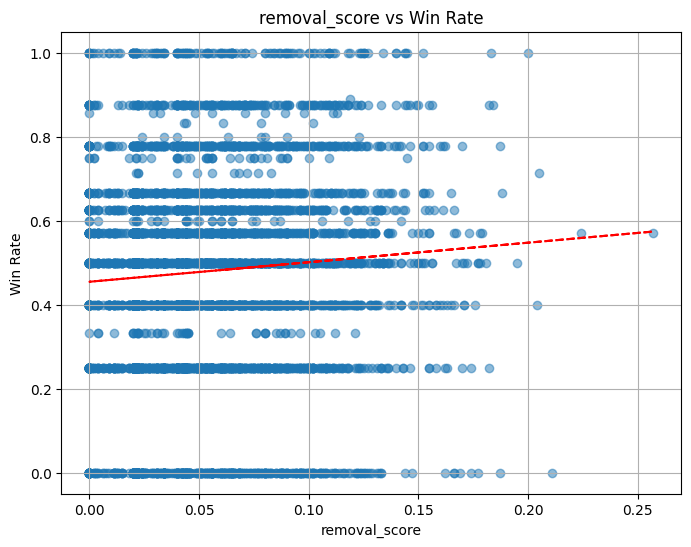

In [ ]:
# Plotting and Correlation Analysis tools

def plot_feature_vs_winrate(selected_games_df, feature_name):
    """
    Plots the relationship between a feature and win rate.
    
    Parameters:
    selected_games_df (pd.DataFrame): DataFrame containing game data.
    feature_name (str): The name of the feature to plot against win rate.
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(selected_games_df[feature_name], selected_games_df["win_rate"], alpha=0.5)
    plt.xlabel(feature_name)
    plt.ylabel("Win Rate")
    plt.title(f"{feature_name} vs Win Rate")
    plt.grid(True)
    m, b = np.polyfit(selected_games_df[feature_name], selected_games_df["win_rate"], 1)
    plt.plot(selected_games_df[feature_name], m * selected_games_df[feature_name] + b, color="red", linestyle="dashed")
    plt.show()

def calc_pearson_wrcorr(df, feature_name):
    """
    Calculates the Pearson correlation coefficient between a feature and win rate.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing game data.
    feature_name (str): The name of the feature to calculate correlation with win rate.
    
    Returns:
    float: Pearson correlation coefficient.
    """
    corr, p_value = pearsonr(df[feature_name], df["win_rate"])
    print(f"Pearson Correlation: {corr:.4f}")
    print(f"P-Value: {p_value:.4f}")

plot_feature_vs_winrate(selected_games_df, "removal_score")


##### Bomb Feature

In [24]:
# Filter bombs based on rarity and win rate threshold
ratings_df["GP WR"] = ratings_df["GP WR"].str.rstrip('%').astype(float) / 100
bombs_df = ratings_df[(ratings_df["Rarity"].isin(["R", "M"])) & (ratings_df["GP WR"] >= 0.54)][["Name", "Color", "Rarity", "ATA", "GP WR"]]


In [ ]:
bombs_df.head(5) # Listed in color order so we're seeing white

,Name,Color,Rarity,ATA,GP WR
1,"Beza, the Bounding Spring",W,M,1.43,0.571
5,Caretaker's Talent,W,R,2.66,0.557
11,Essence Channeler,W,R,2.35,0.546
17,Jackdaw Savior,W,R,2.22,0.550
27,Salvation Swan,W,R,1.99,0.549


Notes:

1. May need to do some type inclusion. If Essence Channeler is only winning 54.6%, people aren't using it properly. 

In [ ]:
def bomb_score_cube(bomb_table):
    """
    Calculates bomb score using [(GP WR - 0.54) * 100] ^ 3.
    """
    if bomb_table.empty:
        return 0
    return (bomb_table["count"] * (((bomb_table["GP WR"] - 0.54) * 100) ** 3)).sum()

bomb_tables = get_type_stats(selected_games_df, bombs_df)

# Apply bomb score formulas to selected_games_df
selected_games_df["bomb_score"] = selected_games_df["draft_id"].map(lambda draft_id: bomb_score_cube(bomb_tables.get(draft_id, pd.DataFrame())))

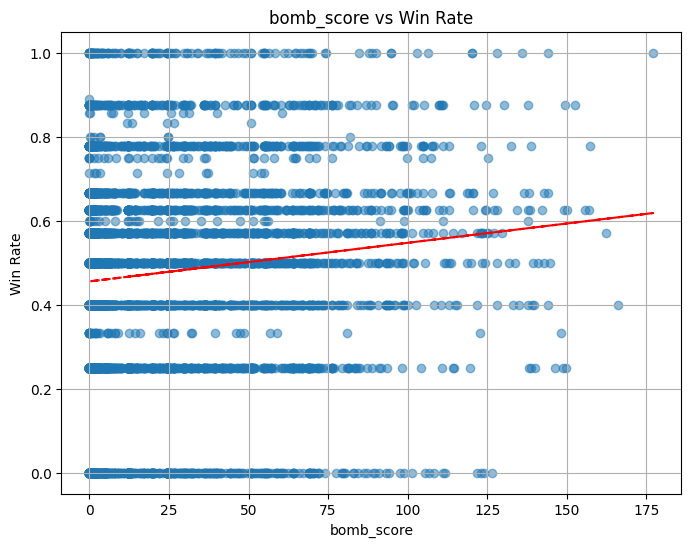

Pearson Correlation: 0.1142
P-Value: 0.0000


In [28]:
plot_feature_vs_winrate(selected_games_df, "bomb_score")
calc_pearson_wrcorr(selected_games_df, "bomb_score")

In [ ]:
# Precompute a bunch of things
land_names = set(cards_df.loc[cards_df["type_line"].str.contains("Land", na=False), "name"])
card_to_cmc = dict(zip(cards_df["name"], cards_df["cmc"]))
token_creators = {"Builder's Talent", "Carrot Cake", "Hop to It", "Otterball Antics", "Season of the Burrow", "Stormchaser's Talent"}
creature_names = set(cards_df.loc[cards_df["type_line"].str.contains("Creature", na=False), "name"])
gp_wr_map = dict(zip(ratings_df["Name"], ratings_df["GP WR"]))

def get_curve(row):
    """
    Extracts the mana curve from a deck row, excluding known land cards.

    - Uses deck_{cardname} columns to determine card counts.
    - References cards_df to get the CMC of each card.
    - Excludes cards already identified as lands.
    - Caps CMC at 6+, lumping high-cost cards together.
    
    Parameters:
    - row: A single row from the deck DataFrame.
    - cards_df: DataFrame containing card names and CMC values.
    - land_names: Precomputed set of land card names.

    Returns:
    - List of integers representing the mana curve.
    """
    curve = [0] * 7  # Index 0 = CMC 0, Index 6 = CMC 6+

    for col in row.index:
        if col.startswith("deck_"):
            card_name = col.split("_", 1)[1]  # Extract card name
            
            if card_name not in land_names:
                cmc = card_to_cmc.get(card_name, None)
                if cmc is not None:  # Ensure the card exists
                    cmc_value = min(int(cmc), 6)  # Cap CMC at 6+ (standard)
                    curve[cmc_value] += row[col]
    return curve


[0, 1, 9, 7, 3, 3, 0]

In [ ]:
def calc_avg_gp_wr_for_row(row):
    """
    Calculates the average GP WR for the deck, weighted by card count.
    - Uses a pre-built dictionary (`gp_wr_map`) for efficient lookup.
    
    Parameters:
    - row: A single row from the deck DataFrame.

    Returns:
    - Weighted average GP WR for the deck, or None if no valid cards.
    """
    
    total_wr = 0
    total_cards = 0

    for col in row.index:
        if col.startswith("deck_"):
            card_name = col.split("_", 1)[1]
            card_count = row[col]  
            
            if card_name not in basic_lands:
                gp_wr = gp_wr_map.get(card_name, None)  # Fast lookup
                
                if gp_wr is not None and not pd.isna(gp_wr):  # Check for valid GP WR
                    total_wr += gp_wr * card_count  
                    total_cards += card_count  

    return total_wr / total_cards if total_cards > 0 else None
#TODO fix the data at the source... or somewhere.... (Frogmite, e.g.)
selected_games_df["avg_gp_wr"] = selected_games_df.apply(calc_avg_gp_wr_for_row, axis=1)
plot_feature_vs_winrate(selected_games_df, "avg_gp_wr")
calc_pearson_wrcorr(selected_games_df, "avg_gp_wr")


In [ ]:
#Different structure because it's adding multiple columns
def add_cmc_columns(df):
    """
    Adds individual CMC columns to a DataFrame based on deck composition.

    Iterates through each row, calculates the mana curve, and assigns values 
    to separate CMC columns (cmc_0, cmc_1, ..., cmc_6).

    Parameters:
      df (pd.DataFrame): DataFrame containing deck data.

    Returns:
      pd.DataFrame: Updated DataFrame with CMC columns added.
    """
    cmc_columns = [f"cmc_{i}" for i in range(7)]
    
    # Initialize columns with zeros
    for col in cmc_columns:
        df[col] = 0

    def process_row(row):
        curve = get_curve(row)  # Generate curve once
        return dict(zip(cmc_columns, curve))  # Convert list to dict for Pandas efficiency

    # Apply function across all rows
    df[cmc_columns] = df.apply(process_row, axis=1).apply(pd.Series)

    return df
add_cmc_columns(selected_games_df)

,draft_id,rank,main_colors,splash_colors,won,deck_Agate Assault,deck_Agate-Blade Assassin,deck_Alania's Pathmaker,"deck_Alania, Divergent Storm",deck_Artist's Talent,deck_Azure Beastbinder,deck_Bakersbane Duo,deck_Bandit's Talent,deck_Banishing Light,deck_Bark-Knuckle Boxer,deck_Barkform Harvester,"deck_Baylen, the Haymaker",deck_Bellowing Crier,"deck_Beza, the Bounding Spring",deck_Blacksmith's Talent,deck_Blooming Blast,deck_Bonebind Orator,deck_Bonecache Overseer,deck_Brambleguard Captain,deck_Brambleguard Veteran,deck_Brave-Kin Duo,deck_Brazen Collector,deck_Brightblade Stoat,deck_Builder's Talent,deck_Bumbleflower's Sharepot,deck_Burrowguard Mentor,deck_Bushy Bodyguard,deck_Byway Barterer,deck_Cache Grab,deck_Calamitous Tide,"deck_Camellia, the Seedmiser",deck_Caretaker's Talent,deck_Carrot Cake,deck_Cindering Cutthroat,"deck_Clement, the Worrywort",...,deck_Valley Floodcaller,deck_Valley Mightcaller,deck_Valley Questcaller,deck_Valley Rally,deck_Valley Rotcaller,deck_Veteran Guardmouse,deck_Vinereap Mentor,"deck_Vren, the Relentless",deck_Wandertale Mentor,deck_War Squeak,deck_Warren Elder,deck_Warren Warleader,deck_Waterspout Warden,deck_Wax-Wane Witness,deck_Wear Down,deck_Whiskerquill Scribe,deck_Whiskervale Forerunner,deck_Wick's Patrol,"deck_Wick, the Whorled Mind",deck_Wildfire Howl,deck_Wishing Well,"deck_Ygra, Eater of All","deck_Zoraline, Cosmos Caller",wins,losses,removal_score,win_rate,bomb_score,color_W,color_U,color_B,color_R,color_G,cmc_0,cmc_1,cmc_2,cmc_3,cmc_4,cmc_5,cmc_6
0,deaa4cdcd3e84d8e8b5a0ea34a0f9d79,gold,BG,WR,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,6,3,0.088,0.666667,44.017,0,0,1,0,1,0,1,9,7,3,3,0
9,676ca08a6f5e49ae9aee978bd62c02b1,silver,UBG,WR,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0.053,0.500000,17.999,0,1,1,0,1,0,2,14,3,2,2,0
15,488a8410974649eb82add4b1a6f54a75,silver,BR,None,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,0.177,0.500000,55.620,0,0,1,1,0,0,1,7,12,2,2,0
21,041c4197d49d4d5ea490cc10b0677822,silver,UG,W,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.000,0.500000,14.364,0,1,0,0,1,0,2,6,8,4,3,0
27,41dafe993991494e9bbf2894af398d25,gold,WR,None,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,6,3,0.021,0.666667,68.921,1,0,0,1,0,0,6,8,8,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29189,cba4ae66ebbd480d9bf3067eac552957,None,RG,WB,1,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,3,0.062,0.571429,4.922,0,0,0,1,1,0,2,6,7,4,3,1
29196,8306cd8dc87541289667b37a43762e91,platinum,UB,R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3,0.080,0.250000,0.217,0,1,1,0,0,0,2,5,8,5,2,1
29200,8c6c93ef1b174923a3394a0c93d5e0aa,platinum,UG,B,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,3,0.027,0.625000,36.501,0,1,0,0,1,0,4,8,5,5,1,0
29208,58ddcca0cf7245e98e8acf320a46d7d2,platinum,WB,None,1,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,7,1,0.067,0.875000,0.000,1,0,1,0,0,0,0,10,5,3,3,2


In [ ]:
# Calc Pearson correlation for each CMC column
cmc_cols = [f"cmc_{i}" for i in range(7)]  # cmc_0 to cmc_6

# Compute correlation for each column
for col in cmc_cols:
    print(f"Calculating correlation for {col}...")
    calc_pearson_wrcorr(selected_games_df, col)


Calculating correlation for cmc_0...
Pearson Correlation: nan
P-Value: nan
Calculating correlation for cmc_1...
Pearson Correlation: -0.0179
P-Value: 0.2066
Calculating correlation for cmc_2...
Pearson Correlation: 0.0608
P-Value: 0.0000
Calculating correlation for cmc_3...
Pearson Correlation: -0.0126
P-Value: 0.3722
Calculating correlation for cmc_4...
Pearson Correlation: -0.0259
P-Value: 0.0671
Calculating correlation for cmc_5...
Pearson Correlation: -0.0166
P-Value: 0.2412
Calculating correlation for cmc_6...
Pearson Correlation: -0.0051
P-Value: 0.7178
Calculating correlation for color_W...
Pearson Correlation: -0.0082
P-Value: 0.5636
Calculating correlation for color_U...
Pearson Correlation: -0.0349
P-Value: 0.0137
Calculating correlation for color_B...
Pearson Correlation: 0.0310
P-Value: 0.0283
Calculating correlation for color_R...
Pearson Correlation: -0.0195
P-Value: 0.1688
Calculating correlation for color_G...
Pearson Correlation: -0.0100
P-Value: 0.4813


C:\Users\aaeam\AppData\Local\Temp\ipykernel_23324\1435865640.py:18: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(df[feature_name], df["win_rate"])


In [ ]:
def categorize_deck_colors(row):
    """
    Assigns a deck to one of 16 color categories based on `main_colors`.
    
    Parameters:
      row (pd.Series): A row from selected_games_df containing `main_colors`.
    
    Returns:
      str: The color category ("W", "WU", ..., "Multi").
    """
    active_colors = sorted(row["main_colors"])  # Sort for consistency
    
    if len(active_colors) == 1:
        return active_colors[0]  # Mono-color deck
    elif len(active_colors) == 2:
        return "".join(active_colors)  # Two-color deck
    else:
        return "Multi"  # Any deck with 3+ colors

# Apply function to categorize decks
selected_games_df["color_category"] = selected_games_df.apply(categorize_deck_colors, axis=1)

# One-hot encode the categories
color_categories = ["W", "U", "B", "R", "G", "WU", "WB", "WR", "WG", "UB", "UR", "UG", "BR", "BG", "RG", "Multi"]
for category in color_categories:
    selected_games_df[f"is_{category}"] = (selected_games_df["color_category"] == category).astype(int)

### Initial NN

We also had some Random Forest and XGBoost models; will likely return to those later for comparison.

In [ ]:
# Define feature categories
cmc_cols = [f"cmc_{i}" for i in range(7)]
color_cols = ["is_W", "is_U", "is_B", "is_R", "is_G", "is_WU", "is_WB", "is_WR", "is_WG",
              "is_UB", "is_UR", "is_UG", "is_BR", "is_BG", "is_RG", "is_Multi"]
deck_cols = [col for col in selected_games_df.columns if col.startswith("deck_")]

# Final feature list
features = ["removal_score", "bomb_score", "avg_gp_wr"] + cmc_cols + color_cols + deck_cols

# Extract only these columns
X = selected_games_df[features]
y = selected_games_df["win_rate"]

# This scaling is bad but we'll leave it for "history"
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", input_shape=(X_scaled.shape[1],)),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.2),  # Regularization
    keras.layers.Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X_scaled, y, epochs=50, batch_size=64, validation_split=0.2, verbose=0)

Epoch 1/50


c:\Users\aaeam\anaconda3\envs\win_c0c1\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3058 - mae: 0.3968 - val_loss: 0.0760 - val_mae: 0.2221
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0636 - mae: 0.2032 - val_loss: 0.0739 - val_mae: 0.2190
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0460 - mae: 0.1695 - val_loss: 0.0738 - val_mae: 0.2194
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0377 - mae: 0.1514 - val_loss: 0.0739 - val_mae: 0.2169
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0327 - mae: 0.1400 - val_loss: 0.0745 - val_mae: 0.2195
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0260 - mae: 0.1254 - val_loss: 0.0753 - val_mae: 0.2193
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0224 - mae: 0.1159 - val_loss: 0.0769 - val_mae: 0.2214
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0199 - mae: 0.1092 - val_loss: 0.0759 - val_mae: 0.2200
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0166 - mae: 0.0989 - va

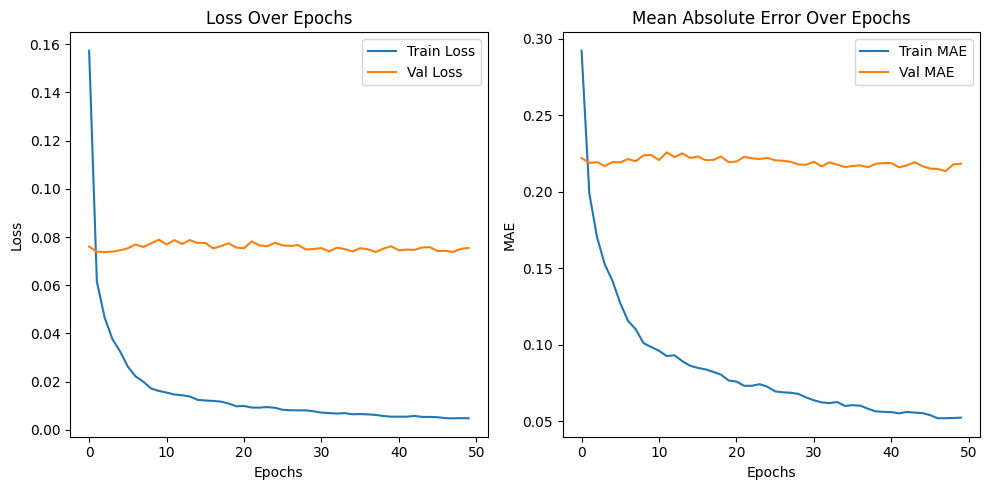

In [ ]:
def plot_training_history(history, metric="mae"):
    """Plots training loss and MAE over epochs."""
    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history[metric], label=f"Train {metric}")
    plt.plot(history[f"val_{metric}"], label=f"Val {metric}")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.title(f"{metric} Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(model.history.history)


In [ ]:
# ^^ Substantial overfitting - define MLP model with stronger regularization
model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X.shape[1],)),
    keras.layers.Dropout(0.3),  # More dropout
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="linear")  # Regression output
])

model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, verbose=0)
plot_training_history(model.history.history)
# vv Overfitting is fixed, but MAE is still too high

Epoch 1/100


c:\Users\aaeam\anaconda3\envs\win_c0c1\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.8881 - mae: 1.2427 - val_loss: 3.5581 - val_mae: 0.2699
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4366 - mae: 0.3664 - val_loss: 2.6670 - val_mae: 0.3050
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5479 - mae: 0.3000 - val_loss: 2.1343 - val_mae: 0.2860
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0504 - mae: 0.2732 - val_loss: 1.7818 - val_mae: 0.2618
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7134 - mae: 0.2393 - val_loss: 1.5442 - val_mae: 0.2569
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4903 - mae: 0.2320 - val_loss: 1.3626 - val_mae: 0.2420
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3215 - mae: 0.2239 - val_loss: 1.2296 - val_mae: 0.2429
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1930 - mae: 0.2193 - val_loss: 1.1160 - val_mae: 0.2337
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0892 - mae: 0.2

In [ ]:
# Make predictions - it's already seen this data so big grain of salt
y_pred = model.predict(X)

# Compute R² score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step
R² Score: 0.0039


## Classification

Regression seems to be a struggle, so we'll experiment with a classification model to see if we can spot decks that did especially well (6 or 7 wins).

In [ ]:
def classify_medal_status(row):
    """Categorizes win count into medal tiers."""
    if row["wins"] == 7:
        return "medaled"
    elif row["wins"] == 6:
        return "almost medal"
    else:
        return "no medal"

# Apply classification
selected_games_df["medal_status"] = selected_games_df.apply(classify_medal_status, axis=1)
selected_games_df["medal_binary"] = (selected_games_df["wins"] >= 6).astype(int)
selected_games_df["medal_status"].value_counts()

In [ ]:

# Define Binary Classification Model
classification_mlp = keras.Sequential([
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="sigmoid")
])

# Stratified split to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(X, selected_games_df["medal_binary"], test_size=0.2, stratify=selected_games_df["medal_binary"], random_state=42)

# Compile classification_mlp for classification
classification_mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train classification_mlp
classification_mlp.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0)
plot_training_history(classification_mlp.history.history, metric="accuracy")

Epoch 1/100


c:\Users\aaeam\anaconda3\envs\win_c0c1\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7395 - loss: 5.0445 - val_accuracy: 0.8110 - val_loss: 2.4893
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8077 - loss: 2.1689 - val_accuracy: 0.8110 - val_loss: 1.5142
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8087 - loss: 1.3983 - val_accuracy: 0.8110 - val_loss: 1.1554
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8070 - loss: 1.0969 - val_accuracy: 0.8110 - val_loss: 0.9760
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8061 - loss: 0.9346 - val_accuracy: 0.8110 - val_loss: 0.8410
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8107 - loss: 0.8170 - val_accuracy: 0.8110 - val_loss: 0.7515
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8122 - loss: 0.7356 - val_accuracy: 0.8110 - val_loss: 0.6984
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8203 - loss: 0.6678 - val_accuracy: 0.8110 - val_loss: 0.6

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


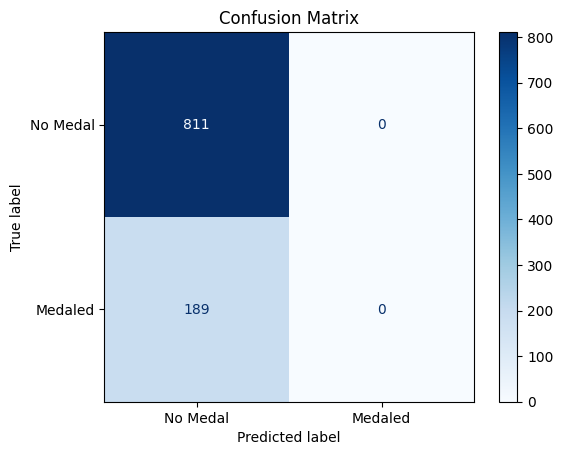

In [ ]:
# Get model predictions (rounded to 0 or 1)
y_pred = (model.predict(X_val) > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Medal", "Medaled"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
# Useless; just predicting majority class

### Synergy

Main logic moved into blb_synergy notebook. 

Temp section to load from file, calculate scores, and save

In [ ]:
def synergy_score(row, gp_wr_map):
    """Calculates synergy strength and applies frequency-based adjustments."""
    
    card1, card2 = row.name  # Extract card pair from MultiIndex
    games_together = row["games_together"]
    pair_wr = row["win_rate"]

    # Get individual card win rates
    card1_wr = gp_wr_map.get(card1, np.nan)
    card2_wr = gp_wr_map.get(card2, np.nan)

    # Ensure both individual win rates exist
    if np.isnan(card1_wr) or np.isnan(card2_wr):
        return np.nan  # If either win rate is missing, return NaN

    # Calculate synergy strength
    expected_wr = (card1_wr + card2_wr) / 2
    synergy_strength = pair_wr - expected_wr

    # Apply frequency-based scaling
    if games_together >= 500:
        adjusted_syn_score = synergy_strength  # No change
    elif games_together >= 100:
        adjusted_syn_score = synergy_strength / 2  # Reduced impact
    else:
        adjusted_syn_score = np.sqrt(max(synergy_strength, 0) * 100) / 100  # Handle negatives safely

    return adjusted_syn_score

# Apply function safely
synergy_table_filtered.loc["synergy_score"] = synergy_table_filtered.apply(synergy_score, axis=1, args=(gp_wr_map,))
synergy_table_filtered.head()


games_together  ...  synergy_score
card1 card2                                  ...               
Savor Druid of the Spade               3414  ...       0.028394
      Glidedive Duo                   23555  ...       0.041340
      Three Tree Rootweaver            8709  ...       0.042591
      Tender Wildguide                 2070  ...       0.062587
      Hazel's Nocturne                 9434  ...       0.056602

[5 rows x 4 columns]

In [ ]:
# Extract deck columns
deck_columns = [col for col in selected_games_df.columns if col.startswith("deck_")]

def calculate_deck_synergy(row, synergy_table_filtered):
    """Computes synergy score for a single deck, excluding basic lands."""
    
    # Build card count dictionary (excluding basic lands)
    card_counts = {col.replace("deck_", ""): row[col] for col in deck_columns if row[col] > 0 and col.replace("deck_", "") not in basic_lands}

    deck_synergy = 0
    
    # Iterate over all unique card pairs
    card_list = list(card_counts.keys())
    for i, card1 in enumerate(card_list):
        for card2 in card_list[i+1:]:
            # Lookup synergy score (check both (card1, card2) and (card2, card1))
            try:
                synergy_score = synergy_table_filtered.xs((card1, card2))["synergy_score"]
            except KeyError:
                try:
                    synergy_score = synergy_table_filtered.xs((card2, card1))["synergy_score"]
                except KeyError:
                    synergy_score = 0  # Default to zero if pair isn't found


            # Scale synergy by card copies
            deck_synergy += synergy_score * card_counts[card1] * card_counts[card2]

    return deck_synergy

# Apply function to dataset
selected_games_df["card_synergy"] = selected_games_df.apply(calculate_deck_synergy, axis=1, args=(synergy_table_filtered,))
#TODO not very efficient
#synergy_dict = synergy_table_filtered["synergy_score"].to_dict()

calc_pearson_wrcorr(selected_games_df, "card_synergy")

### NN Using Synergy

In [ ]:
cmc_cols = [f"cmc_{i}" for i in range(7)]
color_cols = ["is_W", "is_U", "is_B", "is_R", "is_G", "is_WU", "is_WB", "is_WR", "is_WG",
              "is_UB", "is_UR", "is_UG", "is_BR", "is_BG", "is_RG", "is_Multi"]
deck_cols = [col for col in selected_games_df.columns if col.startswith("deck_")]

# Final feature list
features = ["removal_score", "bomb_score", "avg_gp_wr"] + cmc_cols + color_cols + deck_cols

# Extract only these columns
X = selected_games_df[features]
y = selected_games_df["win_rate"]

model = keras.Sequential([
    keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(X.shape[1],)),
    keras.layers.Dropout(0.3),  # More dropout
    keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation="linear")  # Regression output
])

# Compile model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train model for longer
model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, verbose=0)

plot_training_history(model.history.history)

c:\Users\aaeam\anaconda3\envs\win_c0c1\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2400 - mae: 0.9895 - val_loss: 3.3908 - val_mae: 0.3039
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.2076 - mae: 0.3653 - val_loss: 2.3978 - val_mae: 0.2881
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2701 - mae: 0.2919 - val_loss: 1.8786 - val_mae: 0.2868
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7877 - mae: 0.2584 - val_loss: 1.5376 - val_mae: 0.2520
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4826 - mae: 0.2382 - val_loss: 1.3426 - val_mae: 0.2781
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2726 - mae: 0.2240 - val_loss: 1.1621 - val_mae: 0.2455
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1181 - mae: 0.2152 - val_loss: 1.0326 - val_mae: 0.2331
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9986 - mae: 0.2103 - val_loss: 0.9315 - val_mae: 0.2340
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.899

In [189]:
y_pred = model.predict(X)

# Compute R² score
r2 = r2_score(y, y_pred)
print(f"R² Score: {r2:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
R² Score: 0.0083


In [ ]:
cmc_cols = [f"cmc_{i}" for i in range(7)]
color_cols = ["is_W", "is_U", "is_B", "is_R", "is_G", "is_WU", "is_WB", "is_WR", "is_WG",
              "is_UB", "is_UR", "is_UG", "is_BR", "is_BG", "is_RG", "is_Multi"]
deck_cols = [col for col in selected_games_df.columns if col.startswith("deck_")]

X = selected_games_df[features].copy()
y = selected_games_df["win_rate"]

# Final feature list
features = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"] + cmc_cols + color_cols + deck_cols
# Perform train-test split first
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Select scaling method (standard, minmax, or none) inside `build_model()`
def scale_features(X_train, X_val, hp):
    scaler_type = hp.Choice("scaling", ["standard", "minmax", "none"])
    
    if scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        return X_train, X_val  # No scaling
    
    # Apply scaling only to selected features
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()

    X_train_scaled[scale_features_list] = scaler.fit_transform(X_train[scale_features_list])
    X_val_scaled[scale_features_list] = scaler.transform(X_val[scale_features_list])  # Use transform only!
    
    return X_train_scaled, X_val_scaled

# Extract only these columns
#X = selected_games_df.loc[:, features]  # Ensure explicit selection


hp = HyperParameters()
scale_features_list = ["removal_score", "bomb_score", "avg_gp_wr", "card_synergy"]

def build_model(hp):
    """Creates a neural network with tunable hyperparameters, including feature scaling."""
    model = keras.Sequential()

    # Choose feature scaling method
    scaler_type = hp.Choice("scaling", ["standard", "minmax", "none"])
    
    if scaler_type == "standard":
        scaler = StandardScaler()
    elif scaler_type == "minmax":
        scaler = MinMaxScaler()
    else:
        scaler = None  # No scaling

    # Apply scaling only to selected features if applicable
    X_train_scaled = X_train.copy()
    if scaler:
        X_train_scaled[scale_features_list] = scaler.fit_transform(X_train[scale_features_list])

    # Input Layer
    model.add(keras.layers.Dense(512, activation=hp.Choice("activation", ["relu", "leaky_relu", "elu"]),
                                 kernel_regularizer=keras.regularizers.l2(hp.Float("l2", 0.001, 0.01, step=0.001)),
                                 input_shape=(X_train_scaled.shape[1],)))
    model.add(keras.layers.Dropout(hp.Float("dropout", 0.1, 0.4, step=0.05)))

    # Hidden Layers
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dense(256, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(64, activation="relu"))

    model.add(keras.layers.Dropout(hp.Float("dropout", 0.1, 0.4, step=0.05)))  # Final dropout before output

    # Output Layer
    model.add(keras.layers.Dense(1, activation="linear"))

    # Compile with tunable optimizer
    model.compile(optimizer=hp.Choice("optimizer", ["adam", "nadam", "rmsprop"], default="adam"),
                  loss=keras.losses.MSE,
                  metrics=["mae"])
    
    return model

# Define random search tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,  # Number of configurations to test
    executions_per_trial=1,  # Each setting runs once
    directory="nn_tuning",
    project_name="synergy_nn"
)

X_train_scaled, X_val_scaled = scale_features(X_train, X_val, hp)

tuner.search(X_train_scaled, y_train, epochs=50, validation_data=(X_val_scaled, y_val), batch_size=hp.Choice("batch_size", [32, 64, 128]), verbose=1)


Trial 20 Complete [00h 00m 17s]
val_loss: 0.06051138415932655

Best val_loss So Far: 0.05988107621669769
Total elapsed time: 00h 05m 04s


In [13]:
best_trial = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Trial:")
print(f"  Scaling: {best_trial.get('scaling')}")
print(f"  Activation: {best_trial.get('activation')}")
print(f"  L2 Regularization: {best_trial.get('l2')}")
print(f"  Dropout Rate: {best_trial.get('dropout')}")
print(f"  Optimizer: {best_trial.get('optimizer')}")


Best Trial:
  Scaling: minmax
  Activation: leaky_relu
  L2 Regularization: 0.001
  Dropout Rate: 0.35
  Optimizer: rmsprop


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
y_pred = best_model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/paul/miniconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


R² Score: 0.0712
MAE: 0.1897


## Clustering

This is an interesting experiment in its own right - can a clustering algorithm find the 10 main tribal archetypes? For our first approach we will keep it super simple, only including 2 color decks and asking for 10 clusters.

We will use the clustering approach to find more specifics on what cards/features are win predictive within a cluster. Examples:
 - Red/white mice probably does best with a very low curve, plenty of 1-2 drops. Most other decks don't want this
 - Blue/red otters definitely needs a good number of non-creature spells, but this is a detriment in other archetypes

In [16]:
decks2c_df = selected_games_df[selected_games_df["main_colors"].apply(lambda x: len(x) == 2)].copy()
decks2c_df['main_colors'].value_counts()

main_colors
BG    820
WG    684
UG    597
WB    567
WR    459
BR    427
RG    372
UB    352
UR    220
WU    144
Name: count, dtype: int64

In [ ]:
cmc_cols = [f"cmc_{i}" for i in range(7)]
deck_cols = [col for col in decks2c_df.columns if col.startswith("deck_")]

cluster_features = cmc_cols + deck_cols

num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
decks2c_df["cluster"] = kmeans.fit_predict(decks2c_df[cluster_features])


In [18]:
cluster_color_counts = decks2c_df.groupby("cluster")["main_colors"].value_counts().reset_index(name="count")
# Find the most common main_colors for each cluster
top_colors_df = cluster_color_counts.loc[cluster_color_counts.groupby("cluster")["count"].idxmax()].copy()

# Compute percentage within cluster
total_per_cluster = decks2c_df["cluster"].value_counts()
top_colors_df["percentage"] = top_colors_df.apply(lambda row: row["count"] / total_per_cluster[row["cluster"]] * 100, axis=1)

# Display results
print(top_colors_df[["cluster", "main_colors", "percentage"]])


    cluster main_colors  percentage
0         0          WG  100.000000
1         1          UB   69.367589
4         2          BG  100.000000
5         3          UG   74.253731
9         4          BR   99.533800
12        5          RG   99.731903
14        6          WB  100.000000
15        7          WR   99.782135
17        8          WG  100.000000
18        9          BG   99.768519
